<a href="https://colab.research.google.com/github/rnabilahusna/MP_ProductReview/blob/main/MP2_sentiment_analysis_skincare_product_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SENTIMENT ANALYSIS ON SKINCARE PRODUCT REVIEWS IN AMAZON PLAFORM**

## **1.0 Mount Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **2.0 Import Neccessary Libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
sns.set_style("whitegrid")

#set warning
import warnings
warnings.filterwarnings('ignore')

pd.pandas.set_option('display.max_columns', None)

## **3.0 Load Data**

In [3]:
# Specify the path to the concatenated file
concatenated_file_path = '/content/drive/MyDrive/Colab Notebooks/MP1_ProductReview/concatenated_data_new.csv'

# Load the concatenated file into a DataFrame
amazon_reviews = pd.read_csv(concatenated_file_path)

# Make a copy of raw data into a df DataFrame
df = amazon_reviews.copy()

In [4]:
# Output data
df.head(5)

,product,date,title,rating,body,helpful_count
0,Amazon.com: Customer reviews: CeraVe Foaming F...,28/07/2021,1.0 out of 5 stars\nthere’s no way these revie...,1.0,I bought this because I’ve had really oily ski...,2
1,Amazon.com: Customer reviews: CeraVe Foaming F...,23/07/2023,1.0 out of 5 stars\nNot paraben free,1.0,I don’t understand how these brand name compan...,3
2,Amazon.com: Customer reviews: CeraVe Foaming F...,03/03/2022,1.0 out of 5 stars\nCaused reaction- proceed w...,1.0,Bought this for my child to use as a face wash...,10
3,Amazon.com: Customer reviews: CeraVe Foaming F...,28/06/2020,1.0 out of 5 stars\nSlimey,1.0,"So, you know that slime you make when you mix ...",6
4,Amazon.com: Customer reviews: CeraVe Foaming F...,10/12/2023,1.0 out of 5 stars\nProducto abierto,1.0,El producto venía abierto y quedó todo el líqu...,0


## **4.0 Data Exploration**

### **4.1 Dataset Shape**

In [5]:
# Dataset shape (row, column)
df.shape

(15641, 6)

### **4.2 Missing Values**

In [6]:
# Check for missing values
df.isna().sum()

product           0
date              0
title             0
rating            0
body             60
helpful_count     0
dtype: int64

### **4.3 Duplicated Rows**

In [7]:
# Check for duplicate rows
num_duplicate_rows = df.duplicated().sum()
num_duplicate_rows

3663

## **5.0 Data Preparation**

###**5.1 Rename Column**

In [8]:
# Rename columns to make the dataset easier to understand
df.rename(columns={'title': 'Title'}, inplace=True)
df.rename(columns={'rating': 'Rating'}, inplace=True)
df.rename(columns={'body': 'Review'}, inplace=True)
df.rename(columns={'product': 'Product'}, inplace=True)
df.rename(columns={'date': 'Date'}, inplace=True)
df.rename(columns={'helpful_count': 'Helpful Count'}, inplace=True)

### **5.2 Add New Columns - Skin Concern, Brand, Product Type**

In [9]:
# Mapping dictionary (replace these values with your actual mapping)
product_to_skin_concern = {
    # acne-oily-skin
    'Amazon.com: Customer reviews: CeraVe Foaming Facial Cleanser | Daily Face Wash for Oily Skin with Hyaluronic Acid, Ceramides, and Niacinamide| Fragrance Free Paraben Free | 19 Fluid Ounce': 'acne and oily',
    'Amazon.com: Customer reviews: La Roche-Posay Effaclar Purifying Foaming Gel Cleanser for Oily Skin, pH Balancing Daily Face Wash, Oil Free and Soap Free, 13.52 Fl Oz (Pack of 1)': 'acne and oily',
    'Amazon.com: Customer reviews: CeraVe Salicylic Acid Acne Treatment with Glycolic Acid and Lactic Acid | AHA/BHA Acne Gel for Face to Control and Clear Breakouts |1.35 Ounce': 'acne and oily',
    'Amazon.com: Customer reviews: La Roche-Posay Effaclar Duo Dual Action Acne Spot Treatment Cream with Benzoyl Peroxide Acne Treatment for Acne and Blackheads, Lightweight Sheerness, Safe For Sensitive Skin ,0.7 Fl Oz' : 'acne and oily',
    'Amazon.com: Customer reviews: CeraVe AM Facial Moisturizing Lotion SPF 30 | Oil-Free Face Moisturizer with Sunscreen | Non-Comedogenic | 3 Ounce' : 'acne and oily',
    'Amazon.com: Customer reviews: La Roche-Posay Mat Oil-Free Mattifying Moisturizer' : 'acne and oily',
    'Amazon.com: Customer reviews: CeraVe Retinol Serum for Post-Acne Marks and Skin Texture | Pore Refining, Resurfacing, Brightening Facial Serum with Retinol and Niacinamide | Fragrance Free, Paraben Free &amp; Non-Comedogenic| 1 Oz' : 'acne and oily',
    'Amazon.com: Customer reviews: La Roche-Posay Effaclar Salicylic Acid Acne Treatment to Minimize Pores, Clear Acne Blemishes and Post Acne Marks' : 'acne and oily',

    # anti-aging skin
    'Amazon.com: Customer reviews: CeraVe Anti Aging Face Cream with SPF 30 Sunscreen | Anti Wrinkle Cream for Face with Retinol, SPF 30 Sunscreen, Hyaluronic Acid, and Ceramides | White,1.76 Ounce (Pack of 1)' : 'anti-aging',
    'Amazon.com: Customer reviews: La Roche-Posay Redermic R Anti Aging Retinol Cream, Reduces Wrinkles, Fine Lines, and Age Spots with Pure Retinol Face Cream, 1 Fl Oz' : 'anti-aging',
    'Amazon.com: Customer reviews: CeraVe Eye Cream for Wrinkles | Under Eye Cream with Caffeine, Peptides, Hyaluronic Acid, Niacinamide, and Ceramides for Fine Lines | Fragrance Free &amp; Ophthalmologist Tested |0.5 Ounces' : 'anti-aging',
    'Amazon.com: Customer reviews: La Roche-Posay Pigmentclar Dark Circles Eye Cream with Caffeine, Brightens Under Eye Area and Targets Dark Circles' : 'anti-aging',
    'Amazon.com: Customer reviews: CeraVe Anti Aging Retinol Serum | Cream Serum for Smoothing Fine Lines and Skin Brightening | With Retinol, Hyaluronic Acid, Niacinamide, and Ceramides | 1 Ounce' : 'anti-aging',
    'Amazon.com: Customer reviews: La Roche-Posay Pure Retinol Face Serum with Vitamin B3. Anti Aging Face Serum for Lines, Wrinkles &amp; Premature Sun Damage to Resurface &amp; Hydrate. Suitable for Sensitive Skin, 1.0 Fl. Oz' : 'anti-aging',

    # dry skin
    'Amazon.com: Customer reviews: CeraVe Hydrating Facial Cleanser | Moisturizing Non-Foaming Face Wash with Hyaluronic Acid, Ceramides and Glycerin | Fragrance Free Paraben Free | 16 Fluid Ounce' : 'dry',
    'Amazon.com: Customer reviews: La Roche-Posay Toleriane Hydrating Gentle Face Cleanser, Daily Facial Cleanser with Niacinamide and Ceramides for Sensitive Skin, Moisturizing Face Wash for Normal to Dry Skin, Fragrance Free' : 'dry',
    'Amazon.com: Customer reviews: CeraVe Daily Moisturizing Lotion for Dry Skin | Body Lotion &amp; Facial Moisturizer with Hyaluronic Acid and Ceramides | Fragrance Free | 19 Ounce' : 'dry',
    'Amazon.com: Customer reviews: La Roche-Posay Toleriane Double Repair Face Moisturizer, Daily Moisturizer Face Cream with Ceramide and Niacinamide for All Skin Types, Oil Free, Fragrance Free' : 'dry',
    'Amazon.com: Customer reviews: Cerave Hyaluronic Acid Serum for Face with Vitamin B5 and Ceramides | Hydrating Face Serum for Dry Skin | Fragrance Free | 1 Ounce' : 'dry',
    'Amazon.com: Customer reviews: La Roche-Posay Hyalu B5 Pure Hyaluronic Acid Serum for Face, with Vitamin B5, Anti-Aging Serum for Fine Lines and Wrinkles, Hydrating Serum to Plump and Repair Dry Skin, Safe on Sensitive Skin' : 'dry',
}

product_to_brand = {
    # acne-oily-skin
    'Amazon.com: Customer reviews: CeraVe Foaming Facial Cleanser | Daily Face Wash for Oily Skin with Hyaluronic Acid, Ceramides, and Niacinamide| Fragrance Free Paraben Free | 19 Fluid Ounce': 'CeraVe',
    'Amazon.com: Customer reviews: La Roche-Posay Effaclar Purifying Foaming Gel Cleanser for Oily Skin, pH Balancing Daily Face Wash, Oil Free and Soap Free, 13.52 Fl Oz (Pack of 1)': 'La Roche-Posay',
    'Amazon.com: Customer reviews: CeraVe Salicylic Acid Acne Treatment with Glycolic Acid and Lactic Acid | AHA/BHA Acne Gel for Face to Control and Clear Breakouts |1.35 Ounce': 'CeraVe',
    'Amazon.com: Customer reviews: La Roche-Posay Effaclar Duo Dual Action Acne Spot Treatment Cream with Benzoyl Peroxide Acne Treatment for Acne and Blackheads, Lightweight Sheerness, Safe For Sensitive Skin ,0.7 Fl Oz' : 'La Roche-Posay',
    'Amazon.com: Customer reviews: CeraVe AM Facial Moisturizing Lotion SPF 30 | Oil-Free Face Moisturizer with Sunscreen | Non-Comedogenic | 3 Ounce' : 'CeraVe',
    'Amazon.com: Customer reviews: La Roche-Posay Mat Oil-Free Mattifying Moisturizer' : 'La Roche-Posay',
    'Amazon.com: Customer reviews: CeraVe Retinol Serum for Post-Acne Marks and Skin Texture | Pore Refining, Resurfacing, Brightening Facial Serum with Retinol and Niacinamide | Fragrance Free, Paraben Free &amp; Non-Comedogenic| 1 Oz' : 'CeraVe',
    'Amazon.com: Customer reviews: La Roche-Posay Effaclar Salicylic Acid Acne Treatment to Minimize Pores, Clear Acne Blemishes and Post Acne Marks' : 'La Roche-Posay',

    # anti-aging skin
    'Amazon.com: Customer reviews: CeraVe Anti Aging Face Cream with SPF 30 Sunscreen | Anti Wrinkle Cream for Face with Retinol, SPF 30 Sunscreen, Hyaluronic Acid, and Ceramides | White,1.76 Ounce (Pack of 1)' : 'CeraVe',
    'Amazon.com: Customer reviews: La Roche-Posay Redermic R Anti Aging Retinol Cream, Reduces Wrinkles, Fine Lines, and Age Spots with Pure Retinol Face Cream, 1 Fl Oz' : 'La Roche-Posay',
    'Amazon.com: Customer reviews: CeraVe Eye Cream for Wrinkles | Under Eye Cream with Caffeine, Peptides, Hyaluronic Acid, Niacinamide, and Ceramides for Fine Lines | Fragrance Free &amp; Ophthalmologist Tested |0.5 Ounces' : 'CeraVe',
    'Amazon.com: Customer reviews: La Roche-Posay Pigmentclar Dark Circles Eye Cream with Caffeine, Brightens Under Eye Area and Targets Dark Circles' : 'La Roche-Posay',
    'Amazon.com: Customer reviews: CeraVe Anti Aging Retinol Serum | Cream Serum for Smoothing Fine Lines and Skin Brightening | With Retinol, Hyaluronic Acid, Niacinamide, and Ceramides | 1 Ounce' : 'CeraVe',
    'Amazon.com: Customer reviews: La Roche-Posay Pure Retinol Face Serum with Vitamin B3. Anti Aging Face Serum for Lines, Wrinkles &amp; Premature Sun Damage to Resurface &amp; Hydrate. Suitable for Sensitive Skin, 1.0 Fl. Oz' : 'La Roche-Posay',

    # dry skin
    'Amazon.com: Customer reviews: CeraVe Hydrating Facial Cleanser | Moisturizing Non-Foaming Face Wash with Hyaluronic Acid, Ceramides and Glycerin | Fragrance Free Paraben Free | 16 Fluid Ounce' : 'CeraVe',
    'Amazon.com: Customer reviews: La Roche-Posay Toleriane Hydrating Gentle Face Cleanser, Daily Facial Cleanser with Niacinamide and Ceramides for Sensitive Skin, Moisturizing Face Wash for Normal to Dry Skin, Fragrance Free' : 'La Roche-Posay',
    'Amazon.com: Customer reviews: CeraVe Daily Moisturizing Lotion for Dry Skin | Body Lotion &amp; Facial Moisturizer with Hyaluronic Acid and Ceramides | Fragrance Free | 19 Ounce' : 'CeraVe',
    'Amazon.com: Customer reviews: La Roche-Posay Toleriane Double Repair Face Moisturizer, Daily Moisturizer Face Cream with Ceramide and Niacinamide for All Skin Types, Oil Free, Fragrance Free' : 'La Roche-Posay',
    'Amazon.com: Customer reviews: Cerave Hyaluronic Acid Serum for Face with Vitamin B5 and Ceramides | Hydrating Face Serum for Dry Skin | Fragrance Free | 1 Ounce' : 'CeraVe',
    'Amazon.com: Customer reviews: La Roche-Posay Hyalu B5 Pure Hyaluronic Acid Serum for Face, with Vitamin B5, Anti-Aging Serum for Fine Lines and Wrinkles, Hydrating Serum to Plump and Repair Dry Skin, Safe on Sensitive Skin' : 'La Roche-Posay',
}

product_to_product_type = {
    # acne-oily-skin
    'Amazon.com: Customer reviews: CeraVe Foaming Facial Cleanser | Daily Face Wash for Oily Skin with Hyaluronic Acid, Ceramides, and Niacinamide| Fragrance Free Paraben Free | 19 Fluid Ounce': 'Cleanser',
    'Amazon.com: Customer reviews: La Roche-Posay Effaclar Purifying Foaming Gel Cleanser for Oily Skin, pH Balancing Daily Face Wash, Oil Free and Soap Free, 13.52 Fl Oz (Pack of 1)': 'Cleanser',
    'Amazon.com: Customer reviews: CeraVe Salicylic Acid Acne Treatment with Glycolic Acid and Lactic Acid | AHA/BHA Acne Gel for Face to Control and Clear Breakouts |1.35 Ounce': 'Cream',
    'Amazon.com: Customer reviews: La Roche-Posay Effaclar Duo Dual Action Acne Spot Treatment Cream with Benzoyl Peroxide Acne Treatment for Acne and Blackheads, Lightweight Sheerness, Safe For Sensitive Skin ,0.7 Fl Oz' : 'Cream',
    'Amazon.com: Customer reviews: CeraVe AM Facial Moisturizing Lotion SPF 30 | Oil-Free Face Moisturizer with Sunscreen | Non-Comedogenic | 3 Ounce' : 'Moisturizer',
    'Amazon.com: Customer reviews: La Roche-Posay Mat Oil-Free Mattifying Moisturizer' : 'Moisturizer',
    'Amazon.com: Customer reviews: CeraVe Retinol Serum for Post-Acne Marks and Skin Texture | Pore Refining, Resurfacing, Brightening Facial Serum with Retinol and Niacinamide | Fragrance Free, Paraben Free &amp; Non-Comedogenic| 1 Oz' : 'Serum',
    'Amazon.com: Customer reviews: La Roche-Posay Effaclar Salicylic Acid Acne Treatment to Minimize Pores, Clear Acne Blemishes and Post Acne Marks' : 'Serum',

    # anti-aging skin
    'Amazon.com: Customer reviews: CeraVe Anti Aging Face Cream with SPF 30 Sunscreen | Anti Wrinkle Cream for Face with Retinol, SPF 30 Sunscreen, Hyaluronic Acid, and Ceramides | White,1.76 Ounce (Pack of 1)' : 'Cream',
    'Amazon.com: Customer reviews: La Roche-Posay Redermic R Anti Aging Retinol Cream, Reduces Wrinkles, Fine Lines, and Age Spots with Pure Retinol Face Cream, 1 Fl Oz' : 'Cream',
    'Amazon.com: Customer reviews: CeraVe Eye Cream for Wrinkles | Under Eye Cream with Caffeine, Peptides, Hyaluronic Acid, Niacinamide, and Ceramides for Fine Lines | Fragrance Free &amp; Ophthalmologist Tested |0.5 Ounces' : 'Eye Cream',
    'Amazon.com: Customer reviews: La Roche-Posay Pigmentclar Dark Circles Eye Cream with Caffeine, Brightens Under Eye Area and Targets Dark Circles' : 'Eye Cream',
    'Amazon.com: Customer reviews: CeraVe Anti Aging Retinol Serum | Cream Serum for Smoothing Fine Lines and Skin Brightening | With Retinol, Hyaluronic Acid, Niacinamide, and Ceramides | 1 Ounce' : 'Serum',
    'Amazon.com: Customer reviews: La Roche-Posay Pure Retinol Face Serum with Vitamin B3. Anti Aging Face Serum for Lines, Wrinkles &amp; Premature Sun Damage to Resurface &amp; Hydrate. Suitable for Sensitive Skin, 1.0 Fl. Oz' : 'Serum',

    # dry skin
    'Amazon.com: Customer reviews: CeraVe Hydrating Facial Cleanser | Moisturizing Non-Foaming Face Wash with Hyaluronic Acid, Ceramides and Glycerin | Fragrance Free Paraben Free | 16 Fluid Ounce' : 'Cleanser',
    'Amazon.com: Customer reviews: La Roche-Posay Toleriane Hydrating Gentle Face Cleanser, Daily Facial Cleanser with Niacinamide and Ceramides for Sensitive Skin, Moisturizing Face Wash for Normal to Dry Skin, Fragrance Free' : 'Cleanser',
    'Amazon.com: Customer reviews: CeraVe Daily Moisturizing Lotion for Dry Skin | Body Lotion &amp; Facial Moisturizer with Hyaluronic Acid and Ceramides | Fragrance Free | 19 Ounce' : 'Moisturizer',
    'Amazon.com: Customer reviews: La Roche-Posay Toleriane Double Repair Face Moisturizer, Daily Moisturizer Face Cream with Ceramide and Niacinamide for All Skin Types, Oil Free, Fragrance Free' : 'Moisturizer',
    'Amazon.com: Customer reviews: Cerave Hyaluronic Acid Serum for Face with Vitamin B5 and Ceramides | Hydrating Face Serum for Dry Skin | Fragrance Free | 1 Ounce' : 'Serum',
    'Amazon.com: Customer reviews: La Roche-Posay Hyalu B5 Pure Hyaluronic Acid Serum for Face, with Vitamin B5, Anti-Aging Serum for Fine Lines and Wrinkles, Hydrating Serum to Plump and Repair Dry Skin, Safe on Sensitive Skin' : 'Serum',
}

# Map 'Product' column values to 'Skin Concerns' based on the dictionary
df['Skin Concern'] = df['Product'].map(product_to_skin_concern)
df['Brand'] = df['Product'].map(product_to_brand)
df['Product Type'] = df['Product'].map(product_to_product_type)


### **5.3 Concatenate Title with Review**

In [10]:
# Extract subtitle from 'Title' column and concatenate with main review text
df['Title'] = df['Title'].apply(lambda x: x.split('\n')[1] if '\n' in x else '')
df['Review'] = df['Review']+df['Title']
df = df.drop(['Title'], axis=1)

### **5.4 Translate Non-English Reviews**

In [11]:
!pip install langdetect
!pip install googletrans==4.0.0-rc1

In [12]:
from googletrans import Translator
import pandas as pd
from langdetect import detect

# Initialize the translator
translator = Translator()

# Function to translate non-English reviews to English
def translate_to_english(review):
    try:
        language = detect(review)
        if language != 'en':
            translated_review = translator.translate(review, src=language, dest='en').text
            return translated_review
        else:
            return review
    except:
        return review

# Check and translate non-English reviews in the 'Review' column
df['Review'] = df['Review'].apply(lambda x: translate_to_english(x) if isinstance(x, str) else x)

### **5.5 Drop Unnecessary Columns**

In [13]:
# Drop the not needed columns for analysis
df.drop(columns = ['Product'], inplace = True)
df.drop(columns = ['Helpful Count'], inplace = True)
df.drop(columns = ['Date'], inplace = True)

Export Translated Dataset

In [14]:
# OUTPUT FOR CSV
# Define the path where the translated DataFrame want to be saved
output_path = '/content/drive/MyDrive/Colab Notebooks/MP1_ProductReview/data/MP2_translated_reviews.csv'

# Export the DataFrame to a CSV file
df.to_csv(output_path, index=False)

# Display the exported path
print(f"Cleaned csv data has been exported to: {output_path}")

# FOR XLSX
# Define the path where the translated DataFrame wants to be saved
output_path = '/content/drive/MyDrive/Colab Notebooks/MP1_ProductReview/data/MP2_translated_data.xlsx'

# Export the DataFrame to an Excel file
df.to_excel(output_path, index=False)

# Display the exported path
print(f"Cleaned xlsx data has been exported to: {output_path}")

Cleaned csv data has been exported to: /content/drive/MyDrive/Colab Notebooks/MP1_ProductReview/data/MP2_translated_reviews.csv
Cleaned xlsx data has been exported to: /content/drive/MyDrive/Colab Notebooks/MP1_ProductReview/data/MP2_translated_data.xlsx


In [ ]:
# Specify the path to the concatenated file
translated_file_path = '/content/drive/MyDrive/Colab Notebooks/MP1_ProductReview/MP2_translated_data.csv'

# Load the concatenated file into a DataFrame
amazon_reviews = pd.read_csv(translated_file_path)

# Make a copy of raw data into a df DataFrame
df = amazon_reviews.copy()

## **6.0 Data Pre-Processing**

### **6.1 Data Cleaning**

In [15]:
# Remove rows that contain empty cells
df.dropna(inplace = True)

# Remove duplicates
df.drop_duplicates(inplace = True)

In [16]:
df.shape

(9649, 5)

### **6.2 Case Folding**

In [17]:
# Convert the 'review' column to lowercase
df['Review'] = df['Review'].str.lower()

Adding Additional Features - length of, and percentage of punctuations in the text

In [18]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

df['Review Len'] = df['Review'].apply(lambda x: len(x) - x.count(" "))
df['Word Count'] = df['Review'].apply(lambda x: len(str(x).split()))
df['Punct'] = df['Review'].apply(lambda x: count_punct(x))

### **6.3 Tokenization**

In [19]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
# Tokenize the 'review' column
df['Tokens'] = df['Review'].apply(word_tokenize)

### **6.4 Punctuation and Stopword Removal**

In [21]:
import string
import nltk
from nltk.corpus import stopwords
import requests

In [22]:
# Download NLTK stopwords
nltk.download('stopwords')

# Download the stopwords file from GitHub
stopwords_url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt"
response = requests.get(stopwords_url)
stopwords_text = response.text

# Download the custom stopwords file from your repository
custom_stopwords_url = "https://raw.githubusercontent.com/rnabilahusna/MP_ProductReview/main/stopwords-custom.txt"
custom_response = requests.get(custom_stopwords_url)
custom_stopwords_text = custom_response.text

# Define additional custom stopwords
additional_stopwords = ["product", "leaf", "feel", "not"]

# Combine the stopwords from both URLs and add custom stopwords
all_stopwords = set(stopwords.words('english') + stopwords_text.splitlines() + custom_stopwords_text.splitlines() + additional_stopwords)
all_stopwords.remove('not')

# Function to remove punctuation
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation + '’')  # Include the smart quote character
    # Remove punctuation
    text = [word.translate(translator) for word in text]
    # Remove empty strings
    text = [word for word in text if word]  # Filter out empty strings
    return text

# Function to remove stopwords
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in all_stopwords]

# Apply punctuation removal followed by stopwords removal to the "tokens" column
df['NoStopW Tokens'] = df['Tokens'].apply(remove_punctuation)
df['NoStopW Tokens'] = df['NoStopW Tokens'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **6.5 Lemmatization**

In [23]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [24]:
def lemmatize_text(token_list):
    return " ".join([lemmatizer.lemmatize(token) for token in token_list if not token in set(all_stopwords)])

lemmatizer = nltk.stem.WordNetLemmatizer()
df['Lemmatized Tokens'] = df['NoStopW Tokens'].apply(lambda x: lemmatize_text(x))

Export Cleaned Data

In [25]:
# FOR CSV
# Define the path where the cleaned DataFrame want to be saved
output_path = '/content/drive/MyDrive/Colab Notebooks/MP1_ProductReview/data/MP2_cleaned_data.csv'

# Export the DataFrame to a CSV file
df.to_csv(output_path, index=False)

# Display the exported path
print(f"Cleaned csv data has been exported to: {output_path}")

# FOR XLSX
# Define the path where the cleaned DataFrame wants to be saved
output_path = '/content/drive/MyDrive/Colab Notebooks/MP1_ProductReview/data/MP2_cleaned_data.xlsx'

# Export the DataFrame to an Excel file
df.to_excel(output_path, index=False)

# Display the exported path
print(f"Cleaned xlsx data has been exported to: {output_path}")

Cleaned csv data has been exported to: /content/drive/MyDrive/Colab Notebooks/MP1_ProductReview/data/MP2_cleaned_data.csv
Cleaned xlsx data has been exported to: /content/drive/MyDrive/Colab Notebooks/MP1_ProductReview/data/MP2_cleaned_data.xlsx


Import cleaned data

In [6]:
# Specify the path to the concatenated file
cleaned_file_path = '/content/drive/MyDrive/Colab Notebooks/MP1_ProductReview/data/MP2_cleaned_data.csv'

# Load the concatenated file into a DataFrame
cleaned_amazon_reviews = pd.read_csv(cleaned_file_path)

# Make a copy of raw data into a df DataFrame
df = cleaned_amazon_reviews.copy()

## **7.0 Exploratory Data Analysis**

### **7.1 Data Overview**

In [8]:
# Data Overview
print("Data Overview:")
df.head(10)

Data Overview:


,Rating,Review,Skin Concern,Brand,Product Type,Review Len,Word Count,Punct,Tokens,NoStopW Tokens,Lemmatized Tokens
0,1.0,i bought this because i’ve had really oily ski...,acne and oily,CeraVe,Cleanser,883,202,1.6,"['i', 'bought', 'this', 'because', 'i', '’', '...","['summer', 'cleared', 'visits', 'decided', 'hu...",summer cleared visit decided hurt heard terrib...
1,1.0,i don’t understand how these brand name compan...,acne and oily,CeraVe,Cleanser,307,60,2.3,"['i', 'don', '’', 't', 'understand', 'how', 't...","['understand', 'companies', 'putting', 'parabe...",understand company putting parabens product wr...
2,1.0,bought this for my child to use as a face wash...,acne and oily,CeraVe,Cleanser,728,169,1.4,"['bought', 'this', 'for', 'my', 'child', 'to',...","['child', 'breakout', 'tzone', 'caused', 'alle...",child breakout tzone caused allergic reaction ...
3,1.0,"so, you know that slime you make when you mix ...",acne and oily,CeraVe,Cleanser,923,222,4.8,"['so', ',', 'you', 'know', 'that', 'slime', 'y...","['slime', 'mix', 'borax', 'glue', 'feels', 'fe...",slime mix borax glue feel feel slime gunky fra...
4,1.0,the product was open and all the liquid was in...,acne and oily,CeraVe,Cleanser,75,18,1.3,"['the', 'product', 'was', 'open', 'and', 'all'...",['liquid'],liquid
5,1.0,i’m writing this review to hopefully save some...,acne and oily,CeraVe,Cleanser,670,152,2.1,"['i', '’', 'm', 'writing', 'this', 'review', '...","['writing', 'save', 'bad', 'not', 'caused', 'h...",writing save bad not caused horrible break out...
6,1.0,i’m highly against animal cruelty and if only ...,acne and oily,CeraVe,Cleanser,289,67,0.7,"['i', '’', 'm', 'highly', 'against', 'animal',...","['highly', 'animal', 'cruelty', 'cruelty', 'no...",highly animal cruelty cruelty not hyped tbh no...
7,1.0,"the product looks like it was used, it was dir...",acne and oily,CeraVe,Cleanser,53,13,3.8,"['the', 'product', 'looks', 'like', 'it', 'was...","['dirty', 'hairbad']",dirty hairbad
8,1.0,made his pimples worst more painful he figured...,acne and oily,CeraVe,Cleanser,186,43,1.1,"['made', 'his', 'pimples', 'worst', 'more', 'p...","['pimples', 'worst', 'painful', 'figured', 'wo...",pimple worst painful figured worse idk named s...
9,1.0,edit: lol i had a severe allergic reaction two...,acne and oily,CeraVe,Cleanser,928,202,3.6,"['edit', ':', 'lol', 'i', 'had', 'a', 'severe'...","['edit', 'lol', 'severe', 'allergic', 'reactio...",edit lol severe allergic reaction cetaphil rec...


In [9]:
print("\nInformation about the data:")
df.info()


Information about the data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9649 entries, 0 to 9648
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Rating             9649 non-null   float64
 1   Review             9649 non-null   object 
 2   Skin Concern       9649 non-null   object 
 3   Brand              9649 non-null   object 
 4   Product Type       9649 non-null   object 
 5   Review Len         9649 non-null   int64  
 6   Word Count         9649 non-null   int64  
 7   Punct              9649 non-null   float64
 8   Tokens             9649 non-null   object 
 9   NoStopW Tokens     9649 non-null   object 
 10  Lemmatized Tokens  9596 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 829.3+ KB


### **7.2 Statistical Summary**

### **7.2.1 Descriptive Statistics**

In [28]:
# Frequency distribution for 'rating'
rating_counts = df['Rating'].value_counts()

# Sort the frequency distribution based on rating values
sorted_rating_counts = rating_counts.sort_index(ascending=False)

# Mode for 'rating'
mode_rating = df['Rating'].mode().iloc[0]

# Median for 'rating'
median_rating = df['Rating'].median()

# Range for 'rating'
rating_range = sorted_rating_counts.index.max() - sorted_rating_counts.index.min()

# Print mode, median, and range
print("Mode:", mode_rating)
print("Median:", median_rating)
print("Range:", rating_range)

# Print the sorted frequency distribution
print("\nRating Descriptive Statistics:")
print("Frequency Distribution:")
print(sorted_rating_counts)

Mode: 5.0
Median: 3.0
Range: 4.0

Rating Descriptive Statistics:
Frequency Distribution:
Rating
5.0    2915
4.0    1773
3.0    1608
2.0    1395
1.0    1958
Name: count, dtype: int64


In [29]:
# Specify numerical columns
numerical_columns = ['Review Len', 'Word Count']

# Statistical Summary for Numerical Columns
print("\nStatistical Summary for Numerical Columns:")
df[numerical_columns].describe()


Statistical Summary for Numerical Columns:


,Review Len,Word Count
count,9649.000000,9649.000000
mean,219.570215,49.330190
std,251.109369,55.805354
min,2.000000,1.000000
25%,76.000000,16.000000
50%,148.000000,33.000000
75%,274.000000,62.000000
max,5344.000000,1072.000000


### **7.2.2 Non-Parametric Test**

In [30]:
from scipy.stats import mannwhitneyu

# To assess whether there's a significant difference in the distribution of ratings between two brands (independent samples).

# Separate ratings for each brand
cerave_ratings = df[df['Brand'] == 'CeraVe']['Rating']
larocheposay_ratings = df[df['Brand'] == 'La Roche-Posay']['Rating']

# Mann-Whitney U Test
statistic, p_value = mannwhitneyu(cerave_ratings, larocheposay_ratings)

# Display the results
print("\nMann-Whitney U Test:")
print(f"Test Statistic: {statistic}")
print(f"P-Value: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("The difference in ratings between CeraVe and La Roche-Posay is statistically significant.")
else:
    print("There is no statistically significant difference in ratings between CeraVe and La Roche-Posay.")


Mann-Whitney U Test:
Test Statistic: 11248802.0
P-Value: 0.25790424735453876
There is no statistically significant difference in ratings between CeraVe and La Roche-Posay.


### **7.3 Review Text Length Distribution**

### **7.3.1 CeraVe - Review Text Length**

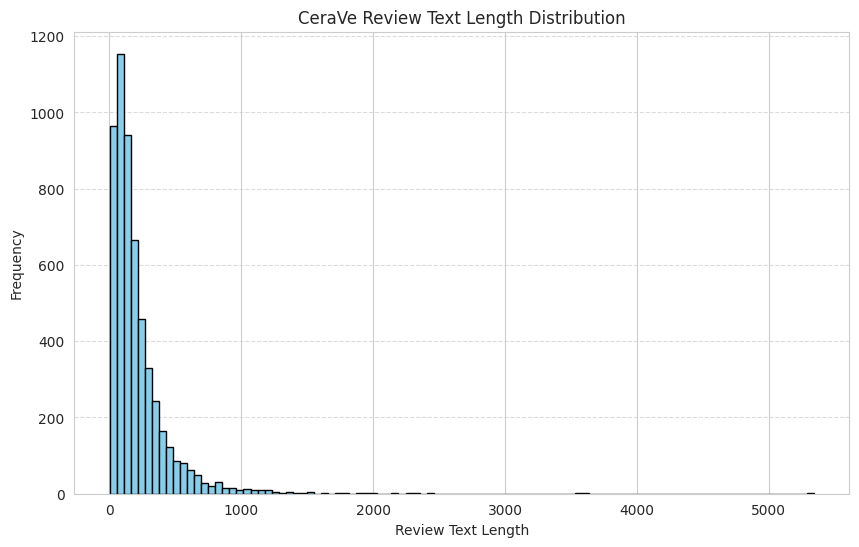

In [31]:
# CeraVe

import matplotlib.pyplot as plt

# Filter the DataFrame for brand 'CeraVe'
df_cerave = df[df['Brand'] == 'CeraVe']

# Filter out rows with empty review text
df_cerave_filtered = df_cerave.dropna(subset=['Review Len'])

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_cerave_filtered['Review Len'], bins=100, color='skyblue', edgecolor='black')
plt.title('CeraVe Review Text Length Distribution')
plt.xlabel('Review Text Length')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### **7.3.2 La Roche-Posay - Review Text Length**

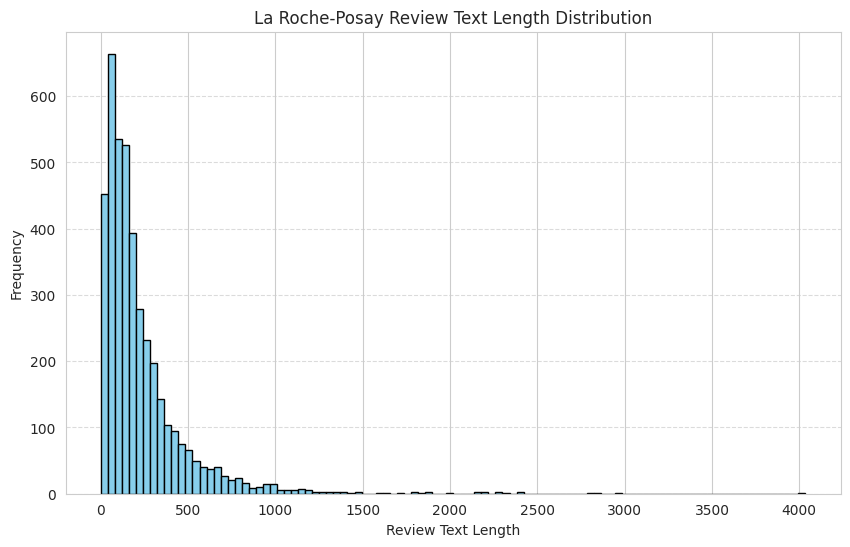

In [32]:
# La Roche-Posay
# Filter the DataFrame for brand 'La Roche-Posay'
df_lrp = df[df['Brand'] == 'La Roche-Posay']

# Filter out rows with empty review text
df_lrp_filtered = df_lrp.dropna(subset=['Review Len'])

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_lrp_filtered['Review Len'], bins=100, color='skyblue', edgecolor='black')
plt.title('La Roche-Posay Review Text Length Distribution')
plt.xlabel('Review Text Length')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## **8.0 Sentiment Analysis**

Creating 'Rating Class' Column

In [11]:
# Figuring out the distribution of categories
df['Rating'].value_counts()

Rating
5.0    2915
1.0    1958
4.0    1773
3.0    1608
2.0    1395
Name: count, dtype: int64

In [12]:
# Deciding the outcome column (product rating) based on the overall score.
# If the score is greater than 3, we take that as high-rated rating
# If the value is less than 3 it is low-rated
# If it is equal to 3, we take that as moderate-rated rating.

def classify_rating(row):
    if row['Rating'] == 3.0:
        val = 'Moderate-rated'
    elif row['Rating'] == 1.0 or row['Rating'] == 2.0:
        val = 'Low-rated'
    elif row['Rating'] == 4.0 or row['Rating'] == 5.0:
        val = 'High-rated'
    else:
        val = -1
    return val

# Applying the function in our new column
# sentiment -> rating_class
df['Rating Class'] = df.apply(classify_rating, axis=1)

In [13]:
df['Rating Class'].value_counts()

Rating Class
High-rated        4688
Low-rated         3353
Moderate-rated    1608
Name: count, dtype: int64

### **8.1 Pre-Trained Model**

### **8.1.1 NLTK Sentiment Analyzer**

In [14]:
# Add label/ground truth to the reviews
df['Label'] = df['Rating'].map({1.0:0, 2.0:0, 3.0:0, 4.0:1, 5.0:1})

In [37]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [38]:
# Create get_sentiment function

def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    sentiment = 1 if scores['pos'] > 0 else 0
    return sentiment

# Apply get_sentiment function
df['VADER Sentiment'] = df['Lemmatized Tokens'].apply(get_sentiment)
df

,Rating,Review,Skin Concern,Brand,Product Type,Review Len,Word Count,Punct,Tokens,NoStopW Tokens,Lemmatized Tokens,Rating Class,Label,VADER Sentiment
0,1.0,i bought this because i’ve had really oily ski...,acne and oily,CeraVe,Cleanser,883,202,1.6,"[i, bought, this, because, i, ’, ve, had, real...","[summer, cleared, visits, decided, hurt, heard...",summer cleared visit decided hurt heard terrib...,Low-rated,0,1
1,1.0,i don’t understand how these brand name compan...,acne and oily,CeraVe,Cleanser,307,60,2.3,"[i, don, ’, t, understand, how, these, brand, ...","[understand, companies, putting, parabens, pro...",understand company putting parabens product wr...,Low-rated,0,0
2,1.0,bought this for my child to use as a face wash...,acne and oily,CeraVe,Cleanser,728,169,1.4,"[bought, this, for, my, child, to, use, as, a,...","[child, breakout, tzone, caused, allergic, rea...",child breakout tzone caused allergic reaction ...,Low-rated,0,1
3,1.0,"so, you know that slime you make when you mix ...",acne and oily,CeraVe,Cleanser,923,222,4.8,"[so, ,, you, know, that, slime, you, make, whe...","[slime, mix, borax, glue, feels, feels, slime,...",slime mix borax glue feel feel slime gunky fra...,Low-rated,0,1
4,1.0,the product was open and all the liquid was in...,acne and oily,CeraVe,Cleanser,75,18,1.3,"[the, product, was, open, and, all, the, liqui...",[liquid],liquid,Low-rated,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15602,5.0,the media could not be loaded.\n ...,dry,La Roche-Posay,Serum,182,34,3.8,"[the, media, could, not, be, loaded, ., my, ab...","[media, not, loaded, absolute, favorite, light...",medium not loaded absolute favorite light abso...,High-rated,1,1
15607,5.0,"i love this entire line, and this product has ...",dry,La Roche-Posay,Serum,73,17,1.4,"[i, love, this, entire, line, ,, and, this, pr...","[love, entire, holy, grail, itemsholy, grail]",love entire holy grail itemsholy grail,High-rated,1,1
15610,5.0,este es el tercer bote que voy comprando porqu...,dry,La Roche-Posay,Serum,198,43,2.5,"[este, es, el, tercer, bote, que, voy, compran...","[este, el, tercer, bote, voy, comprando, porqu...",este el tercer bote voy comprando porque encan...,High-rated,1,1
15614,5.0,moistures and illuminates skin. put imine over...,dry,La Roche-Posay,Serum,55,9,3.6,"[moistures, and, illuminates, skin, ., put, im...","[moistures, illuminates, imine, pondslooks]",moisture illuminates imine pondslooks,High-rated,1,0


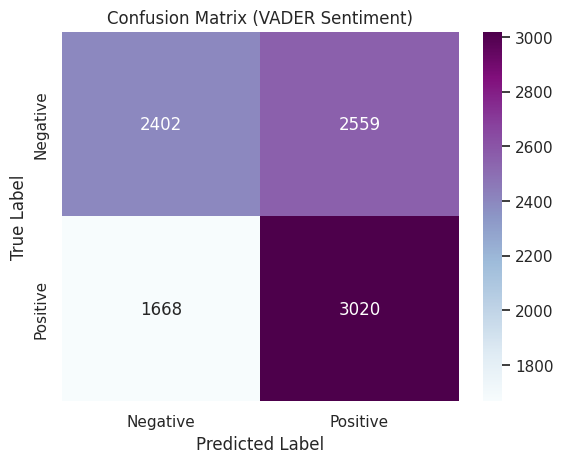



Classification Report (VADER Sentiment):
              precision    recall  f1-score   support

           0       0.59      0.48      0.53      4961
           1       0.54      0.64      0.59      4688

    accuracy                           0.56      9649
   macro avg       0.57      0.56      0.56      9649
weighted avg       0.57      0.56      0.56      9649



In [64]:
from sklearn.metrics import confusion_matrix, classification_report

# Calculate confusion matrix for VADER Sentiment
conf_matrix_vader = confusion_matrix(df['Label'], df['VADER Sentiment'])

# Plot confusion matrix for VADER Sentiment
sns.heatmap(conf_matrix_vader, annot=True, fmt='d', cmap='BuPu', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix (VADER Sentiment)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report for VADER Sentiment
print('\n\nClassification Report (VADER Sentiment):')
print(classification_report(df['Label'], df['VADER Sentiment']))


### **8.1.2 TextBlob**

In [40]:
from textblob import TextBlob

# Function to get sentiment polarity from a text
def get_sentiment_polarity(text):
    analysis = TextBlob(str(text))
    return analysis.sentiment.polarity

# Apply sentiment analysis to the 'body' column
df['TB Polarity Score'] = df['Lemmatized Tokens'].apply(get_sentiment_polarity)

In [41]:
# Function to get sentiment label based on polarity score
def get_sentiment_label(score):
    if score < 0:
        return 0
    else:
        return 1

# Example: Apply sentiment label to the 'polarity_score' column
df['TB Sentiment'] = df['TB Polarity Score'].apply(get_sentiment_label)

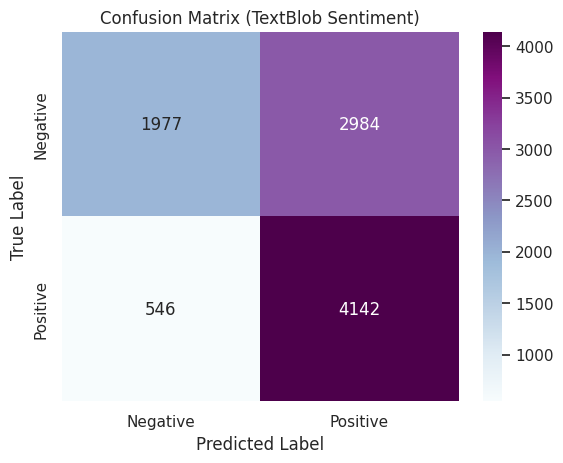



Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.40      0.53      4961
           1       0.58      0.88      0.70      4688

    accuracy                           0.63      9649
   macro avg       0.68      0.64      0.61      9649
weighted avg       0.69      0.63      0.61      9649



In [62]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(df['Label'], df['TB Sentiment'])

# Set the style
sns.set(style="whitegrid")

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuPu', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix (TextBlob Sentiment)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report
print('\n\nClassification Report:')
print(classification_report(df['Label'], df['TB Sentiment']))

### **8.2 Vectorizer: TF-IDF**

In [15]:
X = df[['Lemmatized Tokens', 'Review Len', 'Punct']]
y = df['Label']
print(X.shape)
print(y.shape)

(9649, 3)
(9649,)


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6754, 3)
(2895, 3)
(6754,)
(2895,)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df = 0.5, min_df = 2)
tfidf_train = tfidf.fit_transform(X_train['Lemmatized Tokens'])
tfidf_test = tfidf.transform(X_test['Lemmatized Tokens'])

X_train_vect = pd.concat([X_train[['Review Len', 'Punct']].reset_index(drop=True),
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['Review Len', 'Punct']].reset_index(drop=True),
           pd.DataFrame(tfidf_test.toarray())], axis=1)

# Convert all feature names to strings
X_train_vect.columns = X_train_vect.columns.astype(str)
X_test_vect.columns = X_test_vect.columns.astype(str)

X_train_vect.head()

### **8.2.1 Multinomial Naive Bayes (MNB)**

              precision    recall  f1-score   support

           0       0.76      0.84      0.80      1486
           1       0.81      0.72      0.76      1409

    accuracy                           0.78      2895
   macro avg       0.78      0.78      0.78      2895
weighted avg       0.78      0.78      0.78      2895



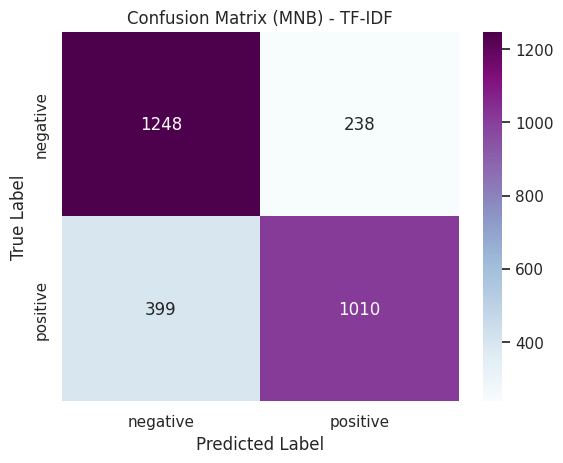

In [68]:
from sklearn.naive_bayes import MultinomialNB

# Initialize and train the classifier
classifier = MultinomialNB()
classifier.fit(X_train_vect, y_train)

# Make predictions
naive_bayes_pred = classifier.predict(X_test_vect)

# Classification Report
print(classification_report(y_test, naive_bayes_pred))

# Confusion Matrix
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, naive_bayes_pred), index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d', cmap='BuPu')
plt.title("Confusion Matrix (MNB) - TF-IDF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### **8.2.2 Support Vector Machine (SVM)**

In [ ]:
from sklearn.svm import SVC

# Initialize and train the SVM classifier
classifier_svm = SVC(kernel='linear', random_state=0)
classifier_svm.fit(X_train_vect, y_train)

# Make predictions using SVM classifier
svm_pred = classifier_svm.predict(X_test_vect)

# Classification Report for SVM
print('Classification Report (SVM):')
print(classification_report(y_test, svm_pred))

# Confusion Matrix for SVM
conf_matrix_svm = confusion_matrix(y_test, svm_pred)

# Plot confusion matrix for SVM
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, naive_bayes_pred), index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d', cmap='BuPu')
plt.title("Confusion Matrix (SVM) - TF-IDF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
